# Mol-2-Vec (NLP) with CATBoost for Partition Coefficient-LogP Predictions 

[23:20:06] WARNING: not removing hydrogen atom without neighbors
[23:20:06] WARNING: not removing hydrogen atom without neighbors
[23:20:06] WARNING: not removing hydrogen atom without neighbors
[23:20:06] WARNING: not removing hydrogen atom without neighbors
[23:20:06] WARNING: not removing hydrogen atom without neighbors
[23:20:06] WARNING: not removing hydrogen atom without neighbors
[23:20:06] WARNING: not removing hydrogen atom without neighbors
[23:20:06] WARNING: not removing hydrogen atom without neighbors
[23:20:06] WARNING: not removing hydrogen atom without neighbors
[23:20:06] WARNING: not removing hydrogen atom without neighbors
[23:20:06] WARNING: not removing hydrogen atom without neighbors
[23:20:06] WARNING: not removing hydrogen atom without neighbors
[23:20:06] WARNING: not removing hydrogen atom without neighbors
[23:20:06] WARNING: not removing hydrogen atom without neighbors
[23:20:06] WARNING: not removing hydrogen atom without neighbors


mol2vec shape: (25870, 300)
features shape: (25870, 300)
0:	learn: 1.5697375	total: 146ms	remaining: 3m 38s
250:	learn: 0.4837041	total: 2.73s	remaining: 13.6s
500:	learn: 0.3685354	total: 5.42s	remaining: 10.8s
750:	learn: 0.3007419	total: 8.49s	remaining: 8.47s
1000:	learn: 0.2528257	total: 12s	remaining: 5.97s
1250:	learn: 0.2177953	total: 15.3s	remaining: 3.05s
1499:	learn: 0.1896169	total: 18.7s	remaining: 0us
Test MAE: 0.35352089405374515
Test RMSE: 0.5082950624888861
Test R2: 0.9142129273232865


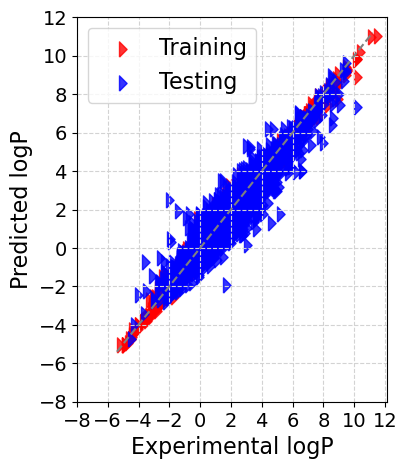

In [1]:
import math
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import seaborn as sns
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from mol2vec.helpers import depict_identifier, plot_2D_vectors, IdentifierTable, mol_to_svg
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from gensim.models import word2vec
from sklearn import preprocessing
from catboost import CatBoostRegressor

# Reading organic solvents viscosity data

# input_dir = 'D:/Postdoc-Work/Manuacripts/NLP-Organic_Solvents-Properties/Comm Chemistry/Revisions_R1/Data_ML-pred/Mol2vec/LogP/'
# dataset = pd.read_csv(input_dir + 'Octanol-Water_LogP_Comm-Chem_Canonical_SMILES.csv')

input_dir = 'D:/Postdoc-Work/Manuacripts/NLP-Organic_Solvents-Properties/Comm Chemistry/Revisions_R1/Data_ML-pred/Chemprop/LogP/'
dataset = pd.read_csv(input_dir + 'logP_dataset_Kaggle+NLP_Canonical_SMILES_Uncertain.csv')

# Sorting dataset with unique SMILES
dataset = dataset.drop_duplicates(subset=['SMILES']).sort_values(by='SMILES')

mol_smiles = dataset['SMILES']
log_visc = dataset['Exp_logp']

# Load the pre-trained Word2Vec model
model_path = 'D:/Postdoc-Work/Results/ML_Codes/Scikit-Learn_ML/Models_MM/Organic-Solvents_Viscosity/mol2vec-master/examples/models/model_300dim.pkl'
model = word2vec.Word2Vec.load(model_path)

# Extraction of identifiers from molecules
os_smiles = [Chem.MolFromSmiles(x) for x in mol_smiles]
os_sentences = [mol2alt_sentence(x, 1) for x in os_smiles]

# Define the DfVec class if not already defined
class DfVec:
    def __init__(self, vector):
        self.vector = vector

def sentences2vec(sentences, model, unseen='UNK'):
    vectors = []
    for sentence in sentences:
        vec = []
        for word in sentence:
            if word in model.wv.key_to_index:
                vec.append(model.wv[word])
            else:
                if unseen in model.wv.key_to_index:
                    vec.append(model.wv[unseen])
                else:
                    vec.append(np.zeros(model.vector_size))
        vectors.append(np.sum(vec, axis=0))
    return vectors

# Convert sentences to vectors
os_mol2vec = [DfVec(x) for x in sentences2vec(os_sentences, model, unseen='UNK')]

# Use the correct attribute name 'vector' instead of 'vec'
np_os_mol2vec = np.array([x.vector for x in os_mol2vec])
print("mol2vec shape:", np_os_mol2vec.shape)

# Standardize the mol2vec features
scaler = preprocessing.StandardScaler()
np_os_mol2vec = scaler.fit_transform(np_os_mol2vec)

print("features shape:", np_os_mol2vec.shape)

# Save the input features and target variable
input_features_df = pd.DataFrame(np_os_mol2vec, columns=[f'feature_{i}' for i in range(np_os_mol2vec.shape[1])])
input_features_df['log_visc'] = log_visc.values
input_features_df.to_csv('input_features.csv', index=False)

# # Split the data into 6 folds
# kf = KFold(n_splits=2, shuffle=True, random_state=536)

# cnt = 1

# # split() method generates indices to split data into training and test set
# for train_index, test_index in kf.split(np_os_mol2vec, log_visc):
#     print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    
#     features_train, features_test = np_os_mol2vec[train_index], np_os_mol2vec[test_index]
#     log_visc_train, log_visc_test = log_visc.iloc[train_index], log_visc.iloc[test_index]
#     smiles_train, smiles_test = mol_smiles.iloc[train_index], mol_smiles.iloc[test_index]
    
#     # training model
#     model = CatBoostRegressor(verbose=250).fit(features_train, log_visc_train)
#     log_visc_pred_train = model.predict(features_train)
    
#     # Save the training results
#     results_df = pd.DataFrame({
#         'SMILES': smiles_train,
#         'log_visc_actual': log_visc_train,
#         'log_visc_pred': log_visc_pred_train
#     })
#     results_df.to_csv(f'Training_Mol2vec-LogP_fold_{cnt}.csv', index=False)
    
#     log_visc_pred_test = model.predict(features_test)
    
#     print(mean_absolute_error(log_visc_test, log_visc_pred_test))
#     print(math.sqrt(mean_squared_error(log_visc_test, log_visc_pred_test)))
#     print(r2_score(log_visc_test, log_visc_pred_test))
    
#     # Save the training results
#     results_df = pd.DataFrame({
#         'SMILES': smiles_test,
#         'log_visc_actual': log_visc_test,
#         'log_visc_pred': log_visc_pred_test
#     })
#     results_df.to_csv(f'Testing_Mol2vec-LogP_fold_{cnt}.csv', index=False)
    
#     # Build scatterplot
#     plt.figure(figsize=(4,5))
    
#     ln = np.arange(min(min(log_visc_train), min(log_visc_test)), max(max(log_visc_train), max(log_visc_test)), 0.2)
#     plt.plot(ln, ln, 'gray', linestyle='--')    #plt.plot(ln, ln, 'r--')
    
#     plt.scatter(log_visc_train, log_visc_pred_train, color='red', label='Training', alpha = 0.8, marker=MarkerStyle("D", fillstyle="right"), s=60,)
#     plt.scatter(log_visc_test, log_visc_pred_test, color='blue', label='Testing', alpha = 0.8, marker=MarkerStyle("D", fillstyle="right"), s=60,)
    
#     plt.xlabel('Experimental logP', fontsize=16)
#     plt.ylabel('Predicted logP', fontsize=16)
    
#     plt.xticks(np.arange(12, -9, step=-2), fontsize=14)
#     plt.yticks(np.arange(12, -9, step=-2), fontsize=14)
    
#     plt.grid(color = '#D3D3D3', linestyle = '--', which='both', axis='both')
#     plt.legend(loc = 'upper left', fontsize=16)
#     plt.savefig(f'CATBoost_Mol2vec-LogP_fold_{cnt}.png', dpi = 1200, bbox_inches='tight')
#     plt.show()
    
#     cnt += 1

seed = 310


# Simple train-test split
X_train, X_test, y_train, y_test, smiles_train, smiles_test = train_test_split(
    np_os_mol2vec, log_visc, mol_smiles, test_size=0.2, random_state=seed)

# Train CatBoost
cat_model = CatBoostRegressor(verbose=250, learning_rate=0.22, n_estimators=1500, l2_leaf_reg=7, rsm=0.6, 
                                   subsample=0.8, random_strength=1, eval_metric='RMSE', min_data_in_leaf=10, 
                                   depth=5, boosting_type='Plain', num_leaves=31)
cat_model.fit(X_train, y_train)

# Predict on train
y_pred_train = cat_model.predict(X_train)
train_df = pd.DataFrame({
    'SMILES': smiles_train.reset_index(drop=True),
    'log_visc_actual': y_train.reset_index(drop=True),
    'log_visc_pred': y_pred_train
})
train_df.to_csv(f'CATBoost_Mol2vec-Training_LogP_Comm-Chem-RS{seed}-25000.csv', index=False)

# Predict on test
y_pred_test = cat_model.predict(X_test)
test_df = pd.DataFrame({
    'SMILES': smiles_test.reset_index(drop=True),
    'log_visc_actual': y_test.reset_index(drop=True),
    'log_visc_pred': y_pred_test
})
test_df.to_csv(f'CATBoost_Mol2vec-Testing_LogP_Comm-Chem-RS{seed}-25000.csv', index=False)

# Print metrics
print("Test MAE:", mean_absolute_error(y_test, y_pred_test))
print("Test RMSE:", math.sqrt(mean_squared_error(y_test, y_pred_test)))
print("Test R2:", r2_score(y_test, y_pred_test))

# Scatterplot
plt.figure(figsize=(4, 5))
ln = np.arange(min(min(y_train), min(y_test)), max(max(y_train), max(y_test)), 0.2)
plt.plot(ln, ln, 'gray', linestyle='--')

plt.scatter(y_train, y_pred_train, color='red', label='Training', alpha=0.8,
            marker=MarkerStyle("D", fillstyle="right"), s=60)
plt.scatter(y_test, y_pred_test, color='blue', label='Testing', alpha=0.8,
            marker=MarkerStyle("D", fillstyle="right"), s=60)

plt.xlabel('Experimental logP', fontsize=16)
plt.ylabel('Predicted logP', fontsize=16)
plt.xticks(np.arange(12, -9, step=-2), fontsize=14)
plt.yticks(np.arange(12, -9, step=-2), fontsize=14)
plt.grid(color='#D3D3D3', linestyle='--', which='both', axis='both')
plt.legend(loc='upper left', fontsize=16)
# plt.savefig('CATBoost_Mol2vec-LogP_Comm-Chem-RS536-25000.png', dpi=1200, bbox_inches='tight')
plt.show()
